In [33]:
# Import of all the necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dataset Download and Extraction

In [ ]:
#Download the dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# Unzip the dataset
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


# Creation of Pandas Dataframe to store the path of the images and their labels

In [9]:
# Image path
img_path = 'data/chest_xray/'

# List the directories
list_of_dirs = ['test', 'train', 'val']
list_of_classes = ['NORMAL', 'PNEUMONIA']

# Creating a dataset from the directory
img_list = []
group_list = []
label_list = []

for group in list_of_dirs:
    for label in list_of_classes:
        path = os.listdir(img_path + group + '/' + label)
        for img in path:
            img_list.append(img_path + group + '/' + label + '/' + img)
            group_list.append(group)
            label_list.append(label)

df = pd.DataFrame({'img_path': img_list, 'group': group_list, 'label': label_list})                   


In [10]:
# Display the dataframe
df.head()

,img_path,group,label
0,data/chest_xray/test/NORMAL/NORMAL2-IM-0195-00...,test,NORMAL
1,data/chest_xray/test/NORMAL/NORMAL2-IM-0086-00...,test,NORMAL
2,data/chest_xray/test/NORMAL/NORMAL2-IM-0373-00...,test,NORMAL
3,data/chest_xray/test/NORMAL/NORMAL2-IM-0326-00...,test,NORMAL
4,data/chest_xray/test/NORMAL/NORMAL2-IM-0380-00...,test,NORMAL


# Breakdown table of images in 'Test', 'Train' and 'Validation' dataset and thier labels

In [11]:
# Images in each group and label
grouped_df = df.groupby(['group', 'label']).size().reset_index(name='counts')
grouped_df

,group,label,counts
0,test,NORMAL,234
1,test,PNEUMONIA,390
2,train,NORMAL,1341
3,train,PNEUMONIA,3875
4,val,NORMAL,8
5,val,PNEUMONIA,8


# Display of some samples of Chest-Xrays

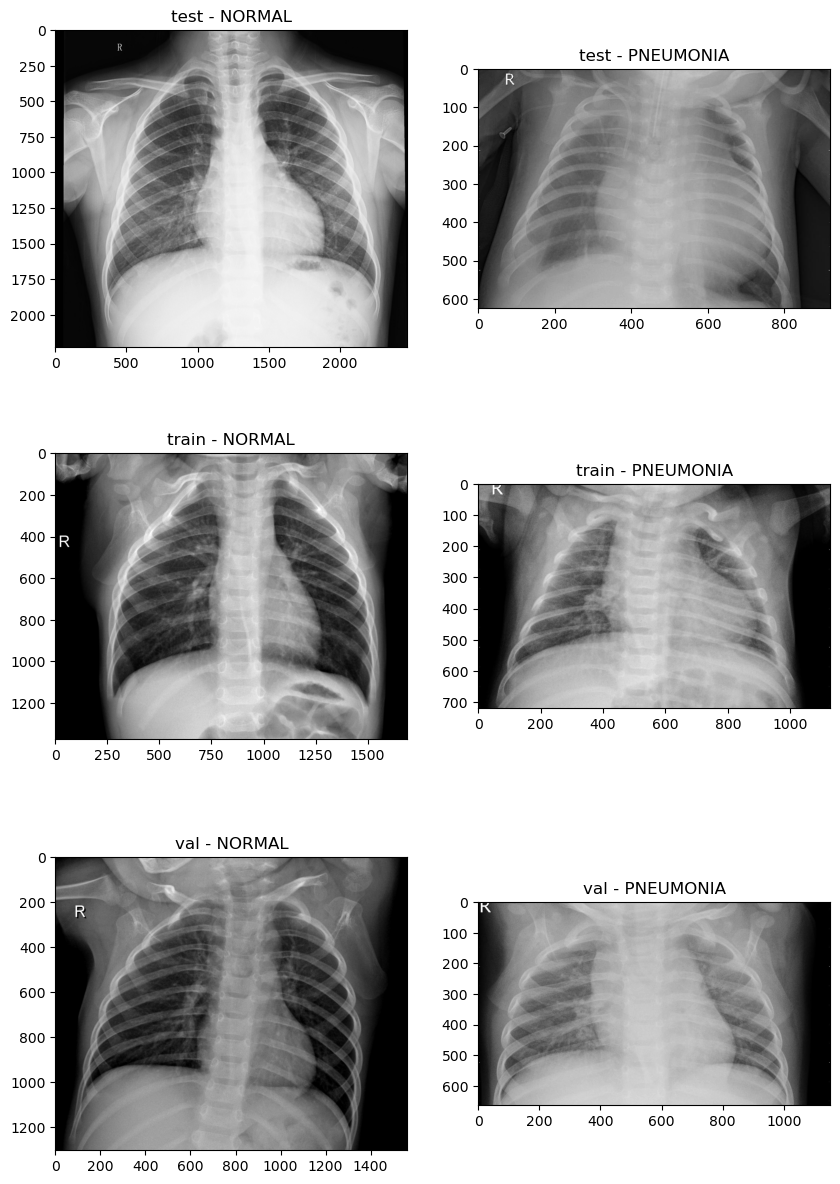

In [12]:
# Print sample images (pre-resize)

groups = df['group'].unique()
labels = df['label'].unique()

fig, ax = plt.subplots(ncols=len(labels), nrows=len(groups), figsize=(10, 15))

for g,group in enumerate(groups):
    for l,label in enumerate(labels):
        img = df[(df['group'] == group) & (df['label'] == label)]['img_path'].values[1]
        img_pic = plt.imread(img)
        ax[g,l].imshow(img_pic, cmap='gray')
        ax[g,l].set_title(group + ' - ' + label)
    






# Creating the Model and Data prepreation as Functions

In [2]:
# Defining the model and its architecture
def create_model(img_height, img_width, filter, seed_value, color_channels=1, dropout=0):
    model = models.Sequential([
        layers.Conv2D(32, (filter, filter), activation='relu',
                      input_shape=(img_height, img_width, color_channels)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout, seed=seed_value),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout, seed=seed_value),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout, seed=seed_value),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [3]:
# Function to prepare the data for the model 
def prepare_data(path, img_height, img_width, batch_size, colour_mode='grayscale'):
     
    prep_ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary',
        color_mode=colour_mode
    )

    return prep_ds



# Optimisation of the Algorithm

Various Hyperparameters was fed through nested loops to find the optimum model and results saved into a CSV file

In [ ]:
# Creating a Dataframe to store the results
df_results = pd.DataFrame(columns=['loss', 'accuracy', 'AUC', 'Precision', 'Recall', 'f1_score', 'img_size', 'colour_mode', 'augment', 'batch_size', 'epochs', 'filter', 'dropout', 'duration'])

# Set random seed
seed_value = 42
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# Loop through different hyperparameters
for epoch in [3, 5]:
    for batch_size in [16, 32, 64]:
        for filter_size in [3, 7]:
            for drop_out in [0.2, 0.5]:
                for size in [150, 300]:
                    for color_mode in ['grayscale', 'rgb']:
                        for augment in [True, False]:

                            start_time = time.time()

                            train_ds = prepare_data('data/chest_xray/train', img_height=size, img_width=size, batch_size=batch_size, colour_mode=color_mode)
                            if augment:
                                data_augmentation = tf.keras.Sequential([
                                    layers.RandomFlip('horizontal'),
                                    layers.RandomRotation(0.2),])
                                train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
                            val_ds = prepare_data('data/chest_xray/val', img_height=size, img_width=size, batch_size=batch_size, colour_mode=color_mode)   
                            test_ds = prepare_data('data/chest_xray/test', img_height=size, img_width=size, batch_size=batch_size, colour_mode=color_mode)
                            
                            if color_mode == 'grayscale':
                                channels = 1
                            else:
                                channels = 3
                            
                            model = create_model(img_height=size, img_width=size, color_channels = channels, filter=filter_size, dropout=drop_out, seed_value=seed_value)
                            
                            model.compile(optimizer='adam',
                                        loss='binary_crossentropy',
                                        metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'f1_score'])
                            
                            history = model.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs= epoch,
                                verbose=0
                            )

                            duration = time.time() - start_time

                            results = model.evaluate(test_ds, return_dict=True)
                            
                            df_results.loc[len(df_results)] = results
                            df_results = df_results.round(3)
                            df_results.loc[len(df_results)-1, 'img_size'] = size
                            df_results.loc[len(df_results)-1, 'colour_mode'] = color_mode
                            df_results.loc[len(df_results)-1, 'augment'] = augment
                            df_results.loc[len(df_results)-1, 'batch_size'] = batch_size
                            df_results.loc[len(df_results)-1, 'epochs'] = epoch
                            df_results.loc[len(df_results)-1, 'filter'] = filter_size
                            df_results.loc[len(df_results)-1, 'dropout'] = drop_out
                            df_results.loc[len(df_results)-1, 'duration'] = duration

                            # Save the results to a csv file
                            df_results.to_csv('output/results.csv', index=False)


# Results of the different models sorted by Accuracy

In [18]:
# Display the results sorted by accuracy
results_df= pd.read_csv('output/resultsx.csv')
results_df.sort_values(by='accuracy', ascending=False, inplace=True)
results_df

,loss,accuracy,AUC,Precision,Recall,f1_score,img_size,colour_mode,augment,batch_size,epochs,filter,dropout,duration
144,0.342,0.877,0.936,0.894,0.910,0.769,150.0,grayscale,True,32.0,5.0,7.0,0.2,57.892
115,0.310,0.867,0.940,0.918,0.864,0.769,150.0,rgb,False,16.0,5.0,7.0,0.2,73.626
131,0.368,0.857,0.925,0.917,0.849,0.769,150.0,rgb,False,32.0,5.0,3.0,0.2,72.228
50,0.467,0.854,0.916,0.873,0.897,0.769,150.0,rgb,True,32.0,3.0,7.0,0.2,42.012
49,0.344,0.853,0.927,0.843,0.938,0.769,150.0,grayscale,False,32.0,3.0,7.0,0.2,34.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.773,0.623,0.622,0.624,0.997,0.769,150.0,grayscale,False,16.0,3.0,7.0,0.5,40.397
27,0.669,0.620,0.579,0.623,0.992,0.769,150.0,rgb,False,16.0,3.0,7.0,0.5,44.652
90,0.688,0.619,0.550,0.630,0.946,0.769,150.0,rgb,True,64.0,3.0,7.0,0.5,40.721
77,0.703,0.417,0.640,0.760,0.097,0.769,300.0,grayscale,False,64.0,3.0,3.0,0.5,141.317


# Running the model with the optimum hyperparameters to save and evaluate

In [20]:
# Setting the ideal hyperparameters for the dataset and the model with seed 42

seed_value = 42
tf.random.set_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# Set the optimal hyperparameters
size = 150
color_mode = 'grayscale'
batch_size = 32
epoch = 5
filter_size = 3
drop_out = 0.2
augment = True




# Prepare the data for the model with ideal hyperparameters
train_ds = prepare_data('data/chest_xray/train', img_height=size, img_width=size, batch_size=batch_size, colour_mode=color_mode)
val_ds = prepare_data('data/chest_xray/val', img_height=size, img_width=size, batch_size=batch_size, colour_mode=color_mode)   
test_ds = prepare_data('data/chest_xray/test', img_height=size, img_width=size, batch_size=batch_size, colour_mode=color_mode)

if augment:
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2)])
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Create the model with ideal hyperparameters
if color_mode == 'grayscale':
    channels = 1
else:
    channels = 3

model = create_model(img_height=size, img_width=size, color_channels = channels, filter=filter_size, dropout=drop_out, seed_value=seed_value)
                            
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'f1_score'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= epoch,
    verbose=0
)

# Evaluate the model
results = model.evaluate(test_ds, return_dict=True)
for key, value in results.items():
    print(f'{key}: {value:.3f}')

# Save the model
model.save('xray_pneumonia_model.h5')


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - AUC: 0.8752 - Precision: 0.7861 - Recall: 0.8947 - accuracy: 0.7886 - f1_score: 0.7523 - loss: 0.4709


AUC: 0.881
Precision: 0.826
Recall: 0.890
accuracy: 0.814
f1_score: 0.769
loss: 0.457


# Creating a Model Test Dataframe to evaluate the optimum model

In [21]:
# Create a dataframe with all the test samples
df_test = df[df['group'] == 'test']

# Change the label to binary
df_test['label'] = df_test['label'].apply(lambda x: 1 if x == 'PNEUMONIA' else 0)
df_test['label'] = df_test['label'].astype(int)

# Display the dataframe
df_test


/tmp/ipykernel_160360/3492348354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'] = df_test['label'].apply(lambda x: 1 if x == 'PNEUMONIA' else 0)
/tmp/ipykernel_160360/3492348354.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'] = df_test['label'].astype(int)


,img_path,group,label
0,data/chest_xray/test/NORMAL/NORMAL2-IM-0195-00...,test,0
1,data/chest_xray/test/NORMAL/NORMAL2-IM-0086-00...,test,0
2,data/chest_xray/test/NORMAL/NORMAL2-IM-0373-00...,test,0
3,data/chest_xray/test/NORMAL/NORMAL2-IM-0326-00...,test,0
4,data/chest_xray/test/NORMAL/NORMAL2-IM-0380-00...,test,0
...,...,...,...
619,data/chest_xray/test/PNEUMONIA/person37_virus_...,test,1
620,data/chest_xray/test/PNEUMONIA/person134_bacte...,test,1
621,data/chest_xray/test/PNEUMONIA/person1626_viru...,test,1
622,data/chest_xray/test/PNEUMONIA/person1645_viru...,test,1


# Using the optimum model to predict and save the outcome to the dataframe through a function to change the Sensitivity of the classfier

In [22]:
# Loop through the test samples and predict the label
def predict_label(treshold):
    for i in range(len(df_test)):

        # Load and prep the image
        # prepare_data(df_test['img_path'].values[i], img_height=150, img_width=150, colour_mode='grayscale')
        img = tf.keras.utils.load_img(df_test['img_path'].values[i], target_size=(150, 150), color_mode='grayscale')
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        
        # Predict the label
        prediction = model.predict(img_array)
        df_test.loc[i, 'prediction'] = prediction[0][0]
        if prediction[0][0] > treshold:
            df_test.loc[i, f'predicted@{treshold}'] = 1
        else:
            df_test.loc[i, f'predicted@{treshold}'] = 0



# Confusion Matrix through a function

In [26]:
# Create a confusion matrix
def create_confusion_matrix(treshold):
    cm = confusion_matrix(df_test['label'], df_test[f'predicted@{treshold}'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax)
    plt.title(f'Confusion Matrix (Cutoff: {treshold})\n', fontsize=16)
    plt.savefig(f'output/confusion_matrix_{treshold}.png')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━

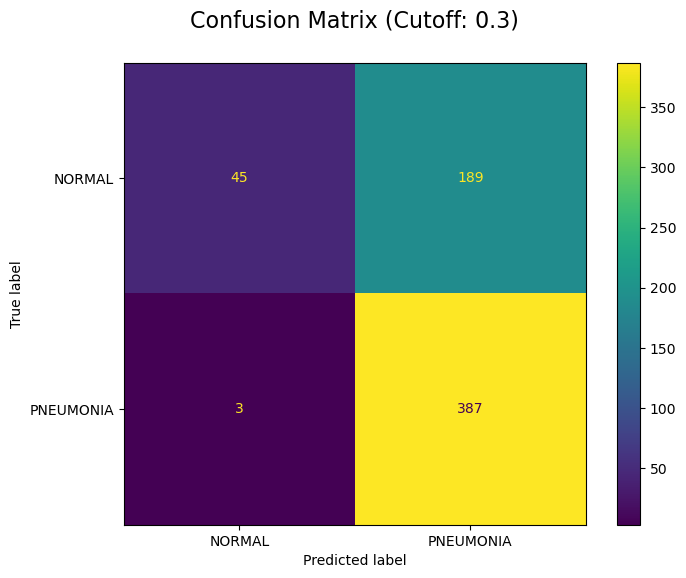

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/tmp/ipykernel_160360/3843033218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[i, f'predicted@{treshold}'] = 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

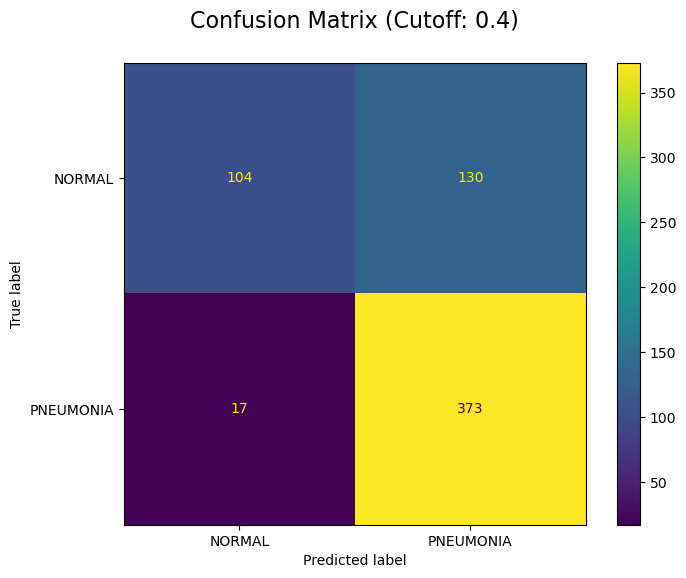

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━

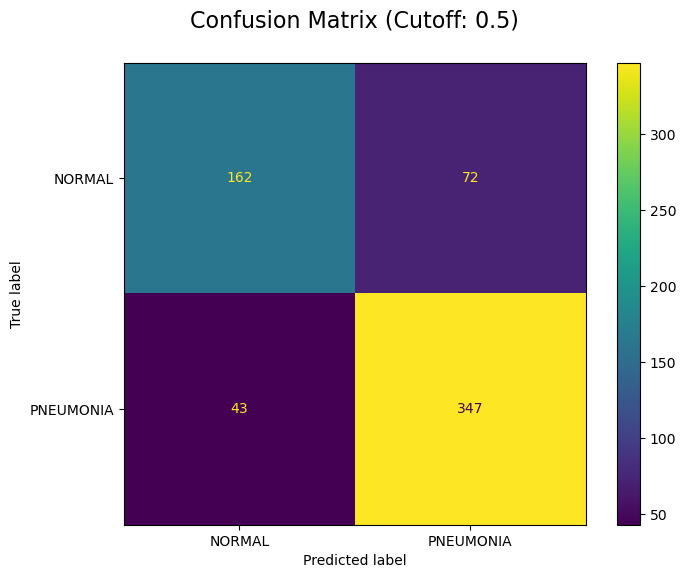

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━

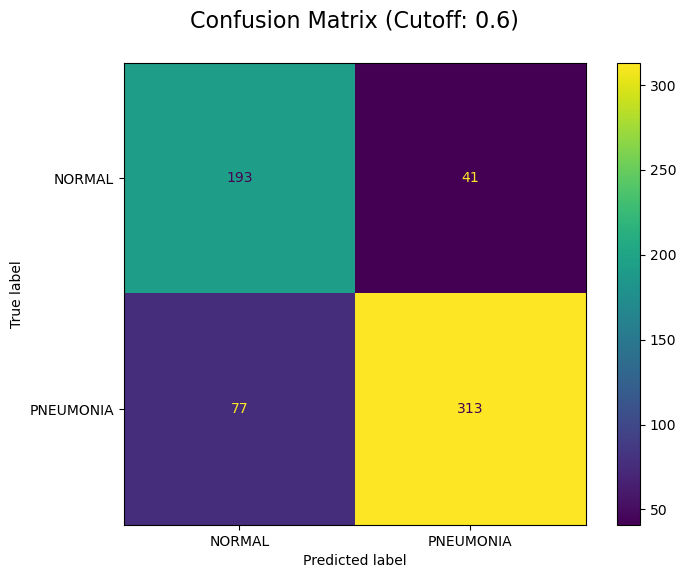

In [52]:
# Run model with different cutoffs
thresholds = [0.3, 0.4, 0.5, 0.6]
for treshold in thresholds:
    predict_label(treshold)
    create_confusion_matrix(treshold)


# Plotting the ROC Curve

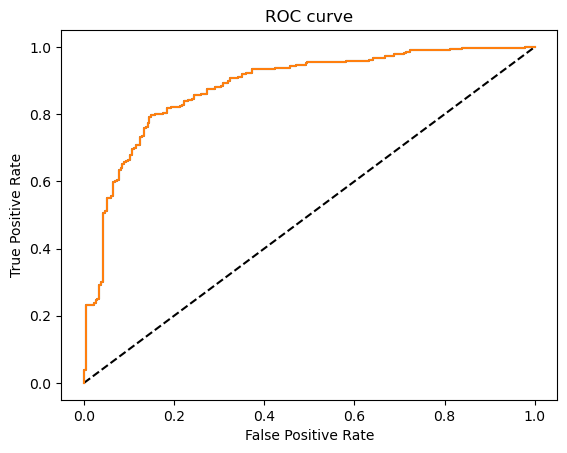

In [39]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(df_test['label'], df_test['prediction'])
plt.plot(fpr, tpr)

# plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

# Label the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig('output/roc_curve.png')
plt.show()



# Calculating the Threshold for 90% Sensitivity

In [51]:
# Finding the treshold for a specific sensitivity
sensitivity = 0.95

# Find the index of the closest TPR to your desired value
closest_index = np.argmin(np.abs(tpr - sensitivity))

# Get the threshold corresponding to this TPR
threshold = thresholds[closest_index]

print(f'Threshold for {sensitivity*100}% Sensitivity')
print('-'*50)
print(f"Threshold for TPR {sensitivity}: {threshold}")
print(f"Actual TPR at this threshold: {tpr[closest_index]}")
print(f"FPR at this threshold: {fpr[closest_index]}")



Threshold for 95.0% Sensitivity
--------------------------------------------------
Threshold for TPR 0.95: 0.4181900918483734
Actual TPR at this threshold: 0.9512820512820512
FPR at this threshold: 0.49145299145299143


# Calculating the threshold at Top-Left Corner of ROC

In [44]:
# Calculate the Euclidean distance from each point to the top-left corner (0, 1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Find the index of the minimum distance
optimal_index = np.argmin(distances)

# Get the threshold corresponding to this point
optimal_threshold = thresholds[optimal_index]

print('Optimal Threshold (Top-Left Corner)')
print('-'*50)
print(f"Optimal Threshold: {optimal_threshold}")
print(f"TPR at Optimal Threshold: {tpr[optimal_index]}")
print(f"FPR at Optimal Threshold: {fpr[optimal_index]}")

Optimal Threshold (Top-Left Corner)
--------------------------------------------------
Optimal Threshold: 0.6094634532928467
TPR at Optimal Threshold: 0.7974358974358975
FPR at Optimal Threshold: 0.14957264957264957


# Testing Model with Image from the Web - Child Xray with Pneumonia
Source of Image: [Radiopedia.org](https://radiopaedia.org/cases/right-middle-lobe-pneumonia-child?lang=gb)

In [60]:
def test_image(model_path, image_path):
   
    # Load the model
    model = tf.keras.models.load_model('xray_pneumonia_model.h5')

    # Load the image
    img = tf.keras.utils.load_img(image_path, target_size=(150, 150), color_mode='grayscale')
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Predict the label
    prediction = model.predict(img_array)
    print(f'Prediction: {prediction}')
    if prediction[0][0] > 0.4:
        print('PNEUMONIA')
    else:
        print('NORMAL')

    # Display the image
    plt.imshow(img, cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: [[0.44942886]]
PNEUMONIA


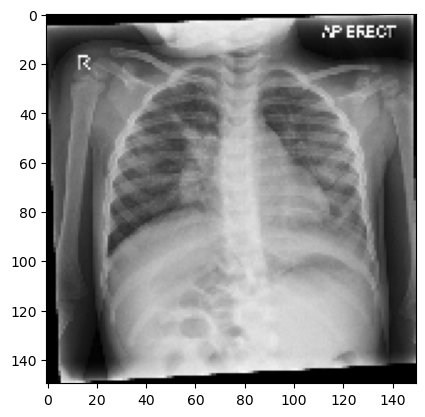

In [61]:
test_image('xray_pneumonia_model.h5', 'postest.jpeg')

# Testing Model with Image from the Web - Child Xray Normal
Source of Image: [Radiopedia.org](https://radiopaedia.org/cases/normal-chest-child)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: [[0.35789403]]
NORMAL


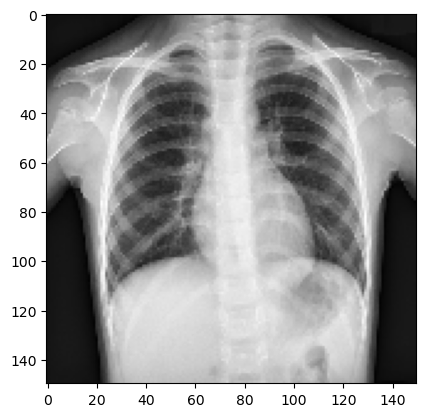

In [62]:
test_image('xray_pneumonia_model.h5', 'negtest.jpeg')